In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.ouster import OusterCrop, OusterNormalize, OusterDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [34]:
# Set path to where you bag files are extracted
#root_path = Path("/home/romet/data/datasets/ut/nvidia-data")
root_path = Path("/home/romet/projects/ut/wp4/dataset")
use_augmentation = False
model_name = f"models/1-pilotnet-lidar-v1"

# Hyperparameters
n_epochs = 100
learning_rate = 1e-4
weight_decay = 0.01

## Datasets

In [35]:

train_paths = [
    root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
    root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
    root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
    root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
    root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
    root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
    root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
    root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
    root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
    root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
    root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
    root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
    root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
    root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
    root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
    root_path / "2021-06-10-12-59-59_e2e_ss4",
    root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
    root_path / "2021-06-10-13-51-34_e2e_ss12",
    root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
    root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
    root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
    root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
    root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards"
]

tr = transforms.Compose([OusterCrop(), OusterNormalize()])
trainset = OusterDataset(train_paths, transform=tr)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,
                                         num_workers=32, pin_memory=True, persistent_workers=True)

torch.Size([3, 68, 264])


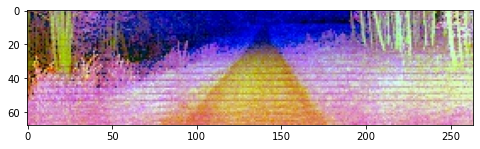

In [36]:
lidar_image = trainset[300]["image"]
print(lidar_image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(lidar_image.permute(1, 2, 0))

In [37]:
valid_paths = [
               root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
               root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
               root_path / "2021-06-14-11-22-05_e2e_rec_ss14"
              ]
validset = OusterDataset(valid_paths, transform=tr)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False,
                                         num_workers=32, pin_memory=True, persistent_workers=True)

## Train model

In [38]:
model = PilotNet()
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), 
                              eps=1e-08, weight_decay=weight_decay, amsgrad=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

trainer = Trainer(model_name, wandb_logging=False)
trainer.train(model, trainloader, validloader, optimizer, criterion, n_epochs)

  0%|          | 0/5048 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

  0%|          | 0/645 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Saving best model.


  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

Saving best model.


  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/5048 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

Early stopping, on epoch: 22.


0.16435423729031584

## Save models

In [39]:
torch.save(model.state_dict(), f"{model_name}/last.pt")
# wandb.save(f"{model_name}/last.pt")
# wandb.save(f"{model_name}/best.pt")

In [40]:
# model_name = f"models/1-pilotnet-base/1cam-batch-v1"
# trainer = Trainer(model_name, wandb_logging=False)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = iter(validloader).next()
inputs = data['image'].to(device)

best_model = PilotNet()
best_model.load_state_dict(torch.load(f"{model_name}/best.pt"))
best_model.to(device)

best_model.eval()
ONNX_FILE_PATH = f"{model_name}/best.onnx"
torch.onnx.export(best_model, inputs, ONNX_FILE_PATH)
#wandb.save(f"{model_name}/best.onnx")

In [42]:
import onnx
onnx.checker.check_model(f"{model_name}/best.onnx")

In [44]:
untrained_model = PilotNet()
untrained_model.to(device)
valid_loss = trainer.evaluate(untrained_model, validloader, criterion)
print(valid_loss)

  0%|          | 0/645 [00:00<?, ?it/s]

0.5162735469061737


In [45]:
valid_loss = trainer.evaluate(best_model, validloader, criterion)
print(valid_loss)

  0%|          | 0/645 [00:00<?, ?it/s]

0.16435423729031584


In [46]:
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False,
                                         num_workers=32, pin_memory=True, persistent_workers=True)

metrics = trainer.calculate_open_loop_metrics(best_model, validloader, 20)
metrics

  0%|          | 0/645 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

{'MAE': 9.417371528714314,
 'RMSE': 34.10862490453449,
 'Max': 823.7471722830139,
 'Whiteness': 106.12206,
 'Expert whiteness': 26.485826221218222}